In [387]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

In [357]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# EDA
### Import Data

In [358]:
job_level_data = pd.read_excel("data/JobLevelData.xlsx")
job_level_data.head()

,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN


### Check for Rows with all NaNs

Let's check for the rows, where all target columns are NaN, meaning that there is no label assigned to the position title. 

There is only 10 rows which are not labeled, which comprise only 0.4% of the data. There is several actions that could be taken:

- Label the data manually or ask data providers to label the data. As there is only 10 entries, the option to ask the client to label this 10 entries is preferable. However, due to the nature of the task, we do not have an access to the communication with the client and we also can't label them because we do not have enough knowledge in the client's data context.  
- Impute the data. There are several possible variants of imputation: 

    -  Fill with default values, such as "Unknown". This is a bad approach as this will introduce an additional class and confuse the model rather than provide valuable data.
    - 
- Remove the rows with missing data.

In [359]:
nan_rows = job_level_data[job_level_data.drop(columns=['Title']).isna().all(axis=1)]
print(f"Percentage of not labeled data: {len(nan_rows) / len(job_level_data) * 100}")
nan_rows

Percentage of not labeled data: 0.4464285714285714


,Title,Column 1,Column 2,Column 3,Column 4
29,CINO,NaN,NaN,NaN,NaN
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
829,Release of Information Tech II,NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN
1406,"Global People Systems, Processes and Informati...",NaN,NaN,NaN,NaN
1713,Supplier Quality Engineer,NaN,NaN,NaN,NaN
1785,RC Environmental and Cyber Specialized Subscri...,NaN,NaN,NaN,NaN
2182,Senior Independedirector and Chair of the Cust...,NaN,NaN,NaN,NaN


### Join Columns values into a single list

In [360]:
job_level_data["Label"] = job_level_data.drop(columns=["Title"]).values.tolist()
job_level_data.drop(columns=["Column 1", "Column 2", "Column 3", "Column 4"], inplace=True)

def remove_nans_from_array(list):
    return [label for label in list if not pd.isna(label)]

job_level_data["Label"] = job_level_data["Label"].apply(remove_nans_from_array)
job_level_data["Label"] = job_level_data["Label"].apply(lambda labels: sorted(labels))
job_level_data

,Title,Label
0,Vice President / Director of Systems Engineering,[Vice President]
1,Systems Engineer; Systems Architect,"[Individual Contributor/Staff, Manager]"
2,"Executive Director, Global IT Infrastructure /...","[Chief Officer, Director]"
3,CTO/Executive Director of Technology Services,"[Chief Officer, Director]"
4,"Vice President, CIO",[Vice President]
...,...,...
2235,Net Software Architect and Team Project Lead,[Manager]
2236,Solutions Architect & Technical Lead,"[Individual Contributor/Staff, Manager]"
2237,"Manager, Salesforcecom Administration and Rele...",[Manager]
2238,Innovation Automation Architect,[Manager]


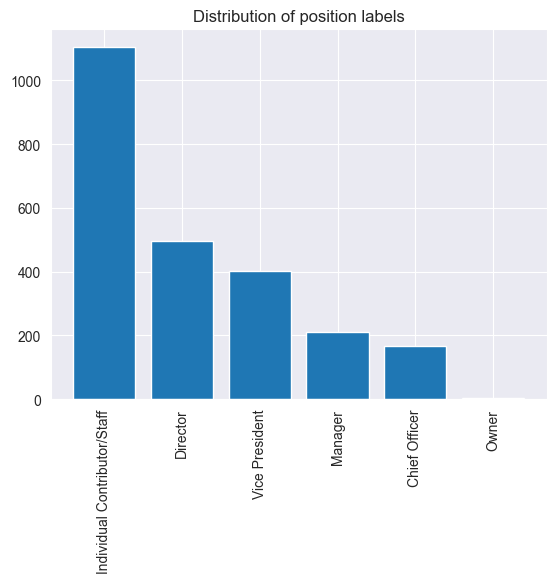

In [361]:
labels_list = [label for labels_list in job_level_data["Label"] for label in labels_list]
labels_count = sorted(Counter(labels_list).items(), key=lambda x: x[1], reverse=True)
labels_count_keys, labels_count_values = zip(*labels_count)

fig, ax = plt.subplots()
ax.bar(labels_count_keys, labels_count_values)
ax.set_title('Distribution of position labels')
plt.xticks(rotation=90) 

plt.show()

It can be observed from the distribution, that the "Owner" label is highly underrepresented. 

In [362]:
job_level_data[job_level_data["Label"].apply(lambda labels: "Owner" in labels)]

,Title,Label
22,CoFounder & CTO,"[Chief Officer, Owner]"
119,"Chief Operating Officer, Co-Founder","[Chief Officer, Owner]"
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1933,"Founder, COO","[Chief Officer, Owner]"


This is a big problem of class underrepresentation. Check if we can hard code the labels based on if the title consists "Owner" or "Founder" / can we assume that this class might be labeled later? 

In [363]:
job_level_data[job_level_data["Title"].apply(lambda title: "Owner" in title)]

,Title,Label
30,Owner & Data Architect,"[Chief Officer, Manager]"
896,"Senior Manager Product Owner, Wireless Expansi...","[Director, Manager, Vice President]"
998,Co-Owner & Marketing Manager,"[Chief Officer, Manager]"
1054,Practice Owner,[Individual Contributor/Staff]
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1481,In App Learning Owner Software,[Individual Contributor/Staff]
1566,Owner Services Coordinator,[Individual Contributor/Staff]
1632,Owner / Franchisee,[Chief Officer]
1828,Senior Software Consultant / Product Owner,[Individual Contributor/Staff]
1847,"Product Owner Digital, Data and IS Direction",[Manager]


In [364]:
mlb = MultiLabelBinarizer()
one_hot_encoded_labels = mlb.fit_transform(job_level_data["Label"])
one_hot_df = pd.DataFrame(one_hot_encoded_labels, columns=mlb.classes_)
job_level_data["Label"] = one_hot_df.values.tolist()

classes_labels = mlb.classes_
print(classes_labels)
job_level_data

['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Owner' 'Vice President']


,Title,Label
0,Vice President / Director of Systems Engineering,"[0, 0, 0, 0, 0, 1]"
1,Systems Engineer; Systems Architect,"[0, 0, 1, 1, 0, 0]"
2,"Executive Director, Global IT Infrastructure /...","[1, 1, 0, 0, 0, 0]"
3,CTO/Executive Director of Technology Services,"[1, 1, 0, 0, 0, 0]"
4,"Vice President, CIO","[0, 0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0, 0]"
2236,Solutions Architect & Technical Lead,"[0, 0, 1, 1, 0, 0]"
2237,"Manager, Salesforcecom Administration and Rele...","[0, 0, 0, 1, 0, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0, 0]"


### Tokenization

In [365]:
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 32
EPOCHS = 10
THRESHOLD = 0.5

tokenizer = BertTokenizer.from_pretrained('bert-base-cased') #not using cased model for a reason

In [366]:
def split_text(text):
    return tokenizer.tokenize(text)

max_len = job_level_data["Title"].apply(split_text).apply(len).max()
print("Maximum lengths of tokenized sentence: ", max_len)

Maximum lengths of tokenized sentence:  24


In [367]:
# handle data preprocessing
class JobTitlesDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_len):
        self.titles = titles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len  # maximum length of tokenized sentence

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        encoded_data = self.tokenizer.encode_plus(
            self.titles[item],
            add_special_tokens=True,  # tokens required for BERT
            max_length=self.max_len,
            return_token_type_ids=False,  # no sentence pair task
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # differentiate between padding and data
            return_tensors='pt'
        )
        return {
            'input_ids': encoded_data['input_ids'].flatten(),
            'attention_mask': encoded_data['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

### Train Test Split

In [368]:
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    job_level_data['Label'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Train data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Train data: (1792,)
Test data: (448,)


In [369]:
train_dataset = JobTitlesDataset(
    titles=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = JobTitlesDataset(
    titles=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

### Model Definition and Training

In [370]:
class JobTitleClassifier(nn.Module):
    def __init__(self, n_classes):
        super(JobTitleClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased') # pre-trained bert model
        self.dropout = torch.nn.Dropout(0.3) # regularization
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes) # classification 
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        output = self.dropout(output.pooler_output)
        output = self.linear(output)
        return output

model = JobTitleClassifier(len(mlb.classes_)).to(device)
print(model)

JobTitleClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [371]:
adam_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
bce_loss = nn.BCEWithLogitsLoss() # includes sigmoid activation

In [372]:
def train_classifier(model,
                     data_loader,
                     loss_fn,
                     optimizer,
                     device):
    model = model.train()
    losses = []
    
    for batch_num, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        true_labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, true_labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return np.mean(losses)


In [373]:
def validation(model,
               data_loader,
               loss_fn,
               device):
    
    model = model.eval()
    losses = []
    predictions = []
    targets = []
    
    # ensures no gradients are computed during test mode
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            true_labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            eval_loss = loss_fn(outputs, true_labels).item()
            losses.append(eval_loss)
            
            preds = torch.sigmoid(outputs)
            predictions.extend(preds.cpu().numpy())
            targets.extend(true_labels.cpu().numpy())
            
    return np.mean(losses), predictions, targets

In [374]:
train_losses = []
val_losses = []

all_targets = []
all_predictions = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    
    train_loss = train_classifier(model, train_loader, bce_loss, adam_optimizer, device)
    train_losses.append(train_loss)
    
    val_loss, predictions, targets = validation(model, test_loader, bce_loss, device)
    val_losses.append(val_loss)
    
    print(f"Training loss: {train_loss:.5f}, Validation loss: {val_loss:.5f}")
    
    predictions = np.array(predictions) >= THRESHOLD
    targets = np.array(targets)
    
    all_targets.extend(targets)
    all_predictions.extend(predictions)
    
    accuracy = accuracy_score(targets, predictions)
    print(f"Accuracy: {accuracy:.5f}")
    
    f1 = f1_score(targets, predictions, average='macro', zero_division=1)
    print(f"F1: {f1}")

Epoch 1/10
Training loss: 0.55859, Validation loss: 0.39832
Accuracy: 0.00893
F1: 0.1680972818311874
Epoch 2/10
Training loss: 0.37049, Validation loss: 0.31356
Accuracy: 0.58482
F1: 0.4657361147739601
Epoch 3/10
Training loss: 0.27955, Validation loss: 0.23005
Accuracy: 0.76116
F1: 0.5973278326338137
Epoch 4/10
Training loss: 0.21379, Validation loss: 0.18714
Accuracy: 0.79911
F1: 0.6803163078910966
Epoch 5/10
Training loss: 0.17409, Validation loss: 0.16400
Accuracy: 0.83705
F1: 0.7722812317375946
Epoch 6/10
Training loss: 0.14889, Validation loss: 0.15204
Accuracy: 0.83482
F1: 0.8060202845782788
Epoch 7/10
Training loss: 0.12943, Validation loss: 0.14064
Accuracy: 0.85491
F1: 0.8262339641399775
Epoch 8/10
Training loss: 0.11429, Validation loss: 0.13232
Accuracy: 0.83929
F1: 0.8356931683900731
Epoch 9/10
Training loss: 0.10093, Validation loss: 0.12866
Accuracy: 0.84152
F1: 0.8405369460373775
Epoch 10/10
Training loss: 0.08924, Validation loss: 0.13199
Accuracy: 0.83705
F1: 0.834271

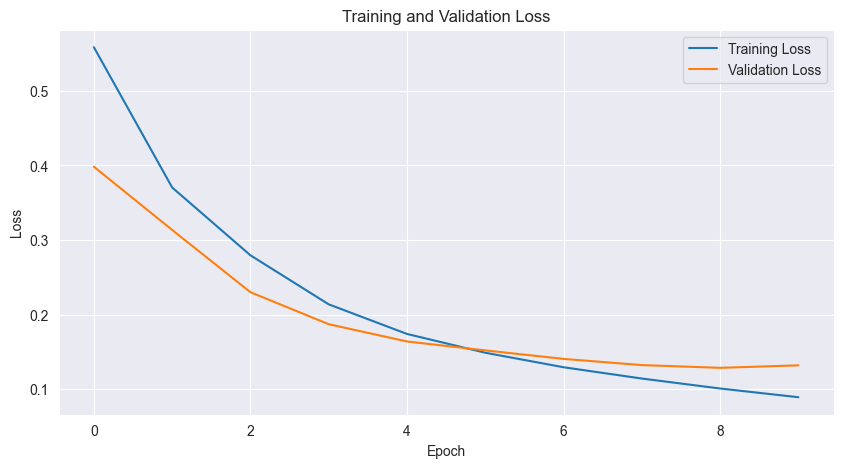

In [375]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

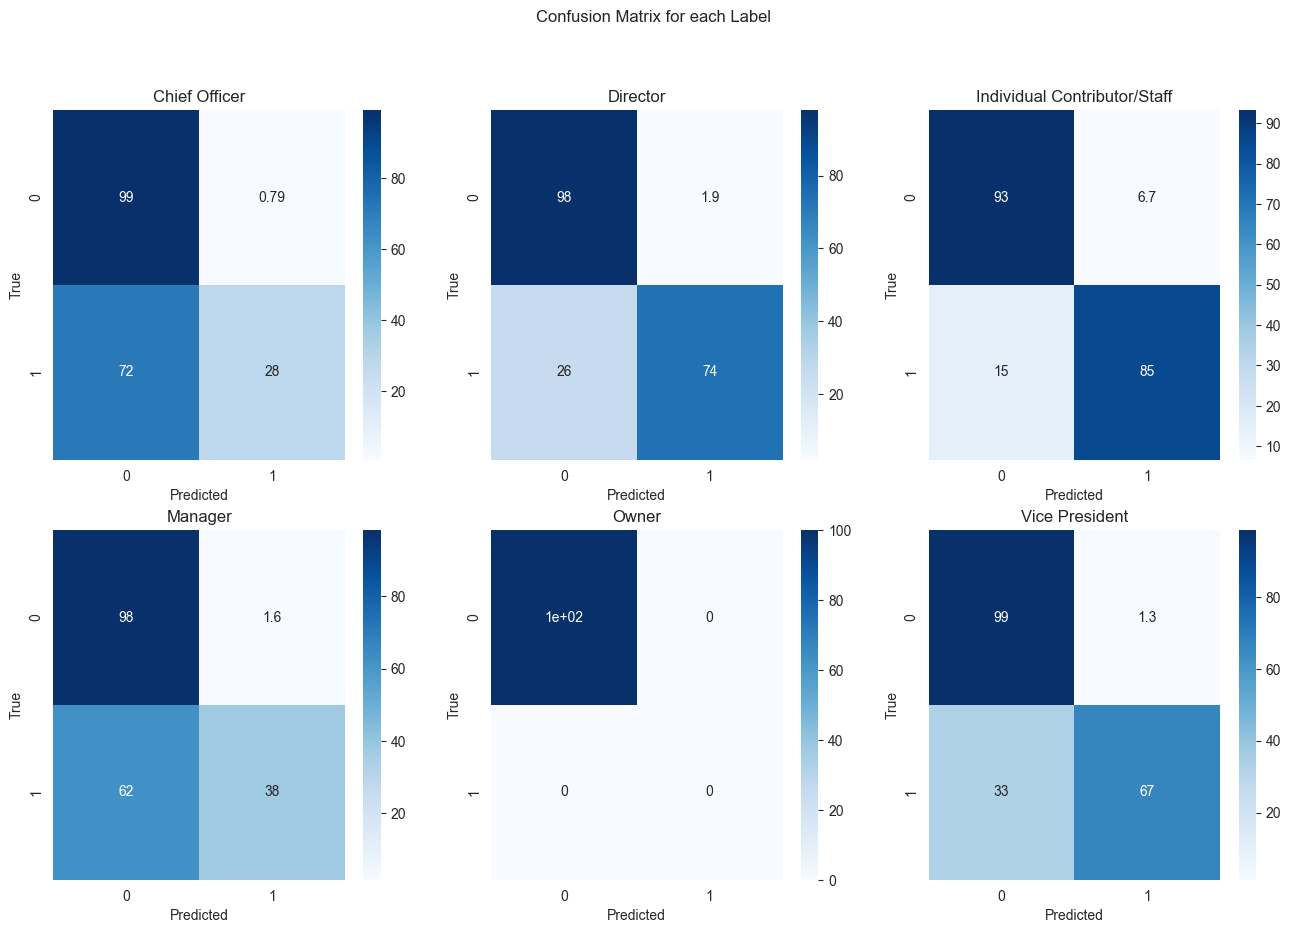

In [450]:
cm = multilabel_confusion_matrix(np.array(all_targets), np.array(all_predictions))

f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.suptitle("Confusion Matrix for each Label")

for i, matrix in enumerate(cm):
    with np.errstate(invalid='ignore'):
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
        normalized_matrix[np.isnan(normalized_matrix)] = 0 
    ax = axes[i//3, i % 3]
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classes_labels[i])

plt.show()